# Mahalanobis distance calculations for the compressed data

CK 2022

### Goal:
Conducting two simpler approaches to running deconvolution on the compressed screen data. So that we can benchmark our regression method against these (spolier: our regression method did a lot better than these approaches)
1) The simplest approach we try is that for each perturbation in the compressed dataset, we calculate the average of the Mahalanobis distances of the wells that the perturbation occurred in. 
2) We then try a more sophisticated approach where rather than simply finding the average of the Mahalanobis distances of the wells a perturbation, we do a bootstrap resampling of these that we can later use to try to find a bootstrapped Mahalanobis distance that is less influenced by outlier wells for a given perturbation. (i.e. say perturbation A has little effect, and occurs in 5 wells, in one of which perturbation B (which has a strong effect) is present as well, causing that one well to have a large Mahalanobis distance. In this case, the boostrap resampling may help us to exlcude that effect from perturbation B).

### What this does:
- For eaach compressed screen in the cell painting dataset
    - For each perturbation
        - Calculates the mean mahalanobis distance from the DMSO wells for the wells that the perturbation occured in
        - Performs bootstrap resampling of these wells & recalculates the mean mahalanobis distance with resampling
        - Saves this distribution of resampled Mahalanobis distances

In [1]:
import os
import sys
import warnings
import random
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import multiprocess as mp
from itertools import repeat
from scipy.stats import mode
from sklearn.metrics import silhouette_score
from sklearn.covariance import MinCovDet,EmpiricalCovariance
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.multitest import multipletests

## Define functions

In [2]:
class HiddenPrints:
    """
    Class to hide unnecessary prints
    """
    
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [1]:
 # Helper function for mahala_dist_CS_bootstrap(
    # for getting perturbation data
def get_X_DMSO_and_X_Pert(adata_pert,adata_DMSO,use_rep,num_pcs):
    if use_rep == 'X':
        X_DMSO = adata_DMSO.X
        X_pert = pd.DataFrame()

        for i in list(range(adata_pert.obsm['design_matrix'].shape[1])):
            pert = pd.DataFrame(np.multiply(adata_pert.X, adata_pert.obsm['design_matrix'][:,i].astype(int)[:, np.newaxis]))
            pert = pert.loc[~(pert==0).all(axis=1)]
            pert['Metadata_perturbation'] = adata_pert.uns['design_matrix_perturbations'][i]
            pert = pert.set_index('Metadata_perturbation')
            X_pert = pd.concat([X_pert, pert])

    elif use_rep == 'X_pca':
        if num_pcs == None:
            print('speficy num_pcs')
            return
        else:
            X_DMSO = adata_DMSO.obsm['X_pca_weighted'][:,0:num_pcs]
            X_pert = pd.DataFrame()

            for i in list(range(adata_pert.obsm['design_matrix'].shape[1])):
                pert = pd.DataFrame(np.multiply(adata_pert.obsm['X_pca_weighted'][:,0:num_pcs], 
                                                adata_pert.obsm['design_matrix'][:,i].astype(int)[:, np.newaxis]))
                pert = pert.loc[~(pert==0).all(axis=1)]
                pert['Metadata_perturbation'] = adata_pert.uns['design_matrix_perturbations'][i]
                pert = pert.set_index('Metadata_perturbation')
                X_pert = pd.concat([X_pert, pert])
            
    elif use_rep == 'X_pca_harmony':
        if num_pcs == None:
            print('speficy num_pcs')
            return
        else:
            X_DMSO = adata_DMSO.obsm['X_pca_harmony_weighted'][:,0:num_pcs]
            X_pert = pd.DataFrame()

            for i in list(range(adata_pert.obsm['design_matrix'].shape[1])):
                pert = pd.DataFrame(np.multiply(adata_pert.obsm['X_pca_harmony_weighted'][:,0:num_pcs], 
                                                adata_pert.obsm['design_matrix'][:,i].astype(int)[:, np.newaxis]))
                pert = pert.loc[~(pert==0).all(axis=1)]
                pert['Metadata_perturbation'] = adata_pert.uns['design_matrix_perturbations'][i]
                pert = pert.set_index('Metadata_perturbation')
                X_pert = pd.concat([X_pert, pert])
    
    else:
        print('use_rep is not valid option')
        return
    
    return X_DMSO, X_pert

# Mahalanobis calculation function, set bootstrap=True to run bootstrap with this
def mahala_dist_CS_bootstrap(adata, use_rep='X', std_cutoff=3, n_sample=int(1e7), assume_centered=False, num_pcs=None,bootstrap=False,num_resamples=1000):
    """
    Calculates the mahalanobis disance of the pert. avg and provides a standard deviation cutoff based on DMSO null dist
    in adata using MCD robust estimator trained on DMSO + avg Pert., stores values as metadata
    """
    
    print("Naive mahalanobis")
    
    # weight PCs by variance explained
    adata.obsm['X_pca_weighted'] = np.multiply(adata.obsm['X_pca'],adata.uns['pca']['variance_ratio'])
    adata.obsm['X_pca_harmony_weighted'] = np.multiply(adata.obsm['X_pca_harmony'],adata.uns['pca']['variance_ratio'])
    
    # select data
    adata_DMSO = adata[adata.obs.Metadata_perturbation=='DMSO',:]
    adata_pert = adata[~(adata.obs.Metadata_perturbation=='DMSO'),:]
    
    # Get the features for the DMSO & perturbations
    X_DMSO, X_pert = get_X_DMSO_and_X_Pert(adata_pert,adata_DMSO,use_rep,num_pcs)

    # average by perturbation
    X_avg_pert = X_pert.groupby('Metadata_perturbation').mean()

    # fit covariance estimator to control + avg. pert. sample
    cov = EmpiricalCovariance(assume_centered=assume_centered).fit(X_DMSO)
    # cov = MinCovDet(assume_centered=assume_centered).fit(X_DMSO)
    

    # calclute perturbation mahalanois distances
    if assume_centered:
        pert_mahal = np.sqrt(cov.mahalanobis(X_avg_pert))
    else:
        pert_mahal = np.sqrt(cov.mahalanobis(X_avg_pert-cov.location_))
    
    # sample DMSO null distribution
    n_rep = mode(X_pert.iloc[:,0].groupby('Metadata_perturbation').count()).mode[0]
    n_DMSO = len(X_DMSO)
    DMSO_null = np.mean(X_DMSO[np.random.randint(0,n_DMSO,size=(n_sample,n_rep))], axis=1)
    
    #calc DMSO null mahalanobis
    if assume_centered:
        DMSO_mahal = np.sqrt(cov.mahalanobis(DMSO_null))
    else:
        DMSO_mahal = np.sqrt(cov.mahalanobis(DMSO_null-cov.location_))
    
    # empirical stdev cutoff for pert vs. null DMSO
    pass_value = (np.std(DMSO_mahal)*std_cutoff)+np.mean(DMSO_mahal)
    
    # build pert table
    mahala_table = pd.DataFrame(pert_mahal, 
                                index=X_avg_pert.index,
                                columns=['mahalanobis'])
    mahala_table['signif_mahala'] = (pert_mahal > pass_value)
    mahala_table.reset_index(inplace=True)
    
    # make mahala table for plotting    
    dmso_table = pd.DataFrame(np.random.choice(DMSO_mahal, size=n_DMSO*5, replace=False),
                              columns=['mahalanobis'])
    dmso_table['Metadata_perturbation'] = 'DMSO'
    dmso_table['signif_mahala'] = 'DMSO'
    
    mahala_table = pd.concat([mahala_table, dmso_table])

    if not bootstrap:
        return mahala_table   
    else:
        
        print("Strap that boot!")
        # strap that boot!
        sample_size = sum(X_pert.index.values==X_pert.index.values[0])  # i.e. num_replicates
        pert_mahals_resampled = np.zeros((len(X_avg_pert.index.values),num_resamples)) # empty array for storing values
        for n in range(num_resamples):
            
            if n % 100 == 0:
                print(str(100*n/num_resamples)+" percent done")

            # For all perturbations, sample wells with replacement and average the sampled wells
            X_pert_resampled = X_pert.groupby('Metadata_perturbation').apply(lambda x: x.sample(sample_size,replace=True))
            X_pert_resampled.index = [x[1] for x in X_pert_resampled.index.values]
            X_pert_resampled.index.name = 'Metadata_perturbation'
            # Note groupby function makes the order the same in X_avg_pert and X_avg_pert_resampled
            X_avg_pert_resampled = X_pert_resampled.groupby('Metadata_perturbation').mean()

            # calclute perturbation mahalanois distances
            if assume_centered:
                pert_mahals_resampled[:,n] = np.sqrt(cov.mahalanobis(X_avg_pert_resampled))
            else:
                pert_mahals_resampled[:,n] = np.sqrt(cov.mahalanobis(X_avg_pert_resampled-cov.location_))

        return mahala_table, pert_mahals_resampled




     

# Function for generating mahalanobis calculations on a given compressed screen run
def run_mahala_for_run(run,data_read_path,data_read_suffix,save_path, adata):
    print(run)
    metadata = pd.read_csv(data_read_path+run+data_read_suffix+"_metadata.csv",index_col=0)
    
    # Layout all of the compression schemes
    compression_methods = metadata.groupby(['Metadata_compression','Metadata_replicates','Metadata_perturbation','Metadata_Plate']).size().reset_index().rename(columns={0:''})
    compression_methods = compression_methods.loc[np.isin(compression_methods['Metadata_perturbation'],['random','random1','random2'])]
        
    for i in range(0,compression_methods.shape[0]):    
        compression = compression_methods['Metadata_compression'].iloc[i]
        replicates = compression_methods['Metadata_replicates'].iloc[i]
        scheme = compression_methods['Metadata_perturbation'].iloc[i]
 
        save_prefix = str(compression) + "x"+str(replicates) + "r" +"_"+str(scheme)
        print(save_prefix)
        
        
        cs_adata = adata[(adata.obs.Metadata_run==run)&\
                       (adata.obs.Metadata_perturbation.isin([scheme, 'DMSO']))&\
                       (adata.obs.Metadata_compression==compression)&\
                       (adata.obs.Metadata_replicates==replicates),:]

        cs_adata.obs['design_index']=cs_adata.obs.Metadata_Plate.astype(str)+'_'+cs_adata.obs.Metadata_Well.astype(str)

        # load in design matricies
        run_design = pd.read_csv(data_read_path+run+data_read_suffix+"_design_matrix.csv",index_col=0).reset_index().rename(columns={'index':'design_index'})

        # add design matrix
        design_mat = pd.DataFrame(cs_adata.obs['design_index']).\
                     merge(run_design,how='left',on='design_index').\
                     drop(['design_index'],axis=1)

        cs_adata.obsm['design_matrix']=np.array(design_mat)
        cs_adata.uns['design_matrix_perturbations'] = design_mat.columns.values.tolist()

        # filter to reps
        plate = list(set(cs_adata.obs.loc[cs_adata.obs.Metadata_perturbation==scheme,'Metadata_Plate'].values))

        cs_adata1 = cs_adata[(cs_adata.obs.Metadata_Plate==plate[0]),:]
        
        # recalc PC's for dataset
        sc.pp.pca(cs_adata1)

        # single plate (no need to batch correct)
        
        # get num of PCs to use (up to 95% var explained)
        sc.pl.pca_variance_ratio(cs_adata1, n_pcs = 50, log=False,show=False)
        num_pcs = sum(np.cumsum(cs_adata1.uns['pca']['variance_ratio']) < 0.90)+1

        print('90% of variance explained by '+str(num_pcs)+' PCs')
        
        
        mahala_table, mahalas_resampled = mahala_dist_CS_bootstrap(cs_adata1,std_cutoff=3, use_rep='X_pca_harmony', num_pcs=num_pcs,bootstrap=True)
        mahala_table['num_pcs_explaining_95var'] = num_pcs
        mahala_table.to_csv(save_path+save_prefix+"mahala_table_DMSO_1e7_samples_17Nov2021_empiricalcov.csv")
        np.save(save_path+save_prefix+"mahalas_resampled_DMSO_1e7_samples_17Nov2021_empiricalcov.npy",mahalas_resampled)



## Loading in adata

In [7]:
pd.set_option('mode.chained_assignment', None)
data_path = '../../../../BEM/Manu_analysis/1_Data/'

## Loading in anndata

# PCA harmony data
OG316 = anndata.read_h5ad(data_path+'09272021_PCH_rd_OG316_table.h5ad')

# add metadata for landmarks
LM_list = ['DMSO','Doxorubicin','Daunorubicin','Fluvastatin','Ticlopidine',
           'Tropicamide','Mycophenolic Acid','Vinblastine Sulfate','Riluzole']

LM_df = pd.DataFrame(columns = LM_list)

for LM in LM_list:
    LM_df[LM] = (OG316.obs.Metadata_perturbation == LM)
    LM_df[LM] = OG316.obs.Metadata_perturbation[(OG316.obs.Metadata_perturbation == LM)]

    OG316.obs[LM] = LM_df[LM]

OG316.obs['landmarks'] = LM_df.astype(str).replace('nan', '').sum(axis=1)
OG316.obs.loc[OG316.obs.landmarks == '', 'landmarks'] = np.nan

# Add feature descriptors
feature_desc = pd.DataFrame(list(OG316.var_names))[0].str.split('_', n=2, expand=True)
feature_desc.columns = ['compartment','measure','channel']
feature_desc['channel'] = feature_desc.channel.str.split('_', expand=False).str.get(1)

OG316.var['compartment'] = feature_desc.compartment.values
OG316.var['measure'] = feature_desc.measure.values
OG316.var['channel'] = feature_desc.channel.values
OG316.var.loc[OG316.var.channel.isna(), 'channel'] = OG316.var.loc[OG316.var.channel.isna(), 'measure']
digits = ['0','1','2','3','4', '5', '6', '7', '8', '9']
OG316.var.loc[OG316.var.channel.isin(digits), 'channel'] = OG316.var.loc[OG316.var.channel.isin(digits), 'measure']
OG316.var.loc[OG316.var.channel == 'Adjacent', 'channel'] = OG316.var.loc[OG316.var.channel == 'Adjacent', 'measure']

# filter to only compressed data
C316 = OG316[~OG316.obs.Metadata_run.isin(['GT_run2', 'GT_run1_batch1']),:]


# Running the calculations

Trying to set attribute `.obs` of view, copying.


CS_run1
2.0x5.0r_random
90% of variance explained by 11 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


Trying to set attribute `.obs` of view, copying.


2.0x7.0r_random
90% of variance explained by 11 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


Trying to set attribute `.obs` of view, copying.


4.0x3.0r_random
90% of variance explained by 9 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


Trying to set attribute `.obs` of view, copying.


4.0x5.0r_random
90% of variance explained by 9 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


Trying to set attribute `.obs` of view, copying.


4.0x7.0r_random
90% of variance explained by 8 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


Trying to set attribute `.obs` of view, copying.


8.0x3.0r_random
90% of variance explained by 8 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


Trying to set attribute `.obs` of view, copying.


8.0x5.0r_random
90% of variance explained by 7 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


Trying to set attribute `.obs` of view, copying.


8.0x7.0r_random
90% of variance explained by 8 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


Trying to set attribute `.obs` of view, copying.


CS_run2
2.0x5.0r_random
90% of variance explained by 11 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


Trying to set attribute `.obs` of view, copying.


2.0x7.0r_random
90% of variance explained by 10 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


Trying to set attribute `.obs` of view, copying.


4.0x3.0r_random
90% of variance explained by 9 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


Trying to set attribute `.obs` of view, copying.


4.0x5.0r_random
90% of variance explained by 9 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


Trying to set attribute `.obs` of view, copying.


4.0x7.0r_random
90% of variance explained by 9 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


Trying to set attribute `.obs` of view, copying.


8.0x3.0r_random
90% of variance explained by 8 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


Trying to set attribute `.obs` of view, copying.


8.0x5.0r_random
90% of variance explained by 8 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


Trying to set attribute `.obs` of view, copying.


8.0x7.0r_random
90% of variance explained by 9 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


Trying to set attribute `.obs` of view, copying.


CS_run3
2.0x3.0r_random1
90% of variance explained by 9 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


Trying to set attribute `.obs` of view, copying.


2.0x3.0r_random2
90% of variance explained by 9 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


Trying to set attribute `.obs` of view, copying.


2.0x7.0r_random1
90% of variance explained by 9 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


Trying to set attribute `.obs` of view, copying.


2.0x7.0r_random2
90% of variance explained by 9 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


Trying to set attribute `.obs` of view, copying.


16.0x5.0r_random1
90% of variance explained by 7 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:554: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  n_rows * rcParams['figure.figsize'][1],
/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


Trying to set attribute `.obs` of view, copying.


16.0x5.0r_random2
90% of variance explained by 7 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


Trying to set attribute `.obs` of view, copying.


32.0x5.0r_random1
90% of variance explained by 6 PCs
Naive mahalanobis


ValueError: operands could not be broadcast together with shapes (48,50) (47,) 

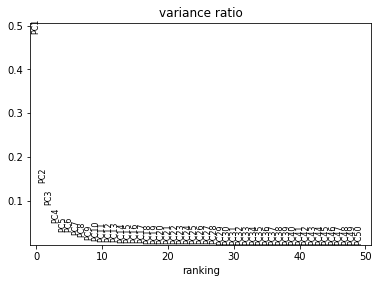

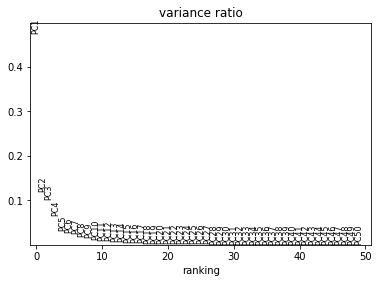

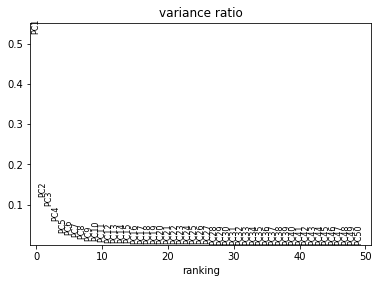

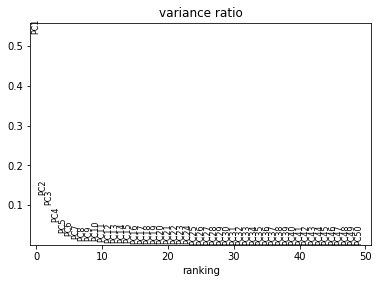

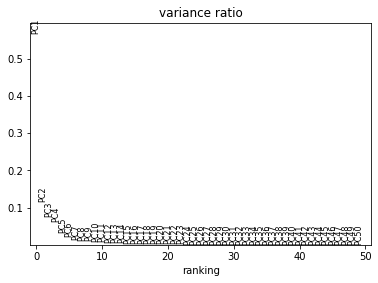

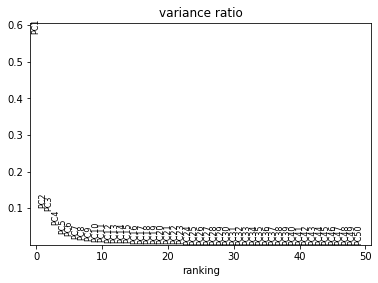

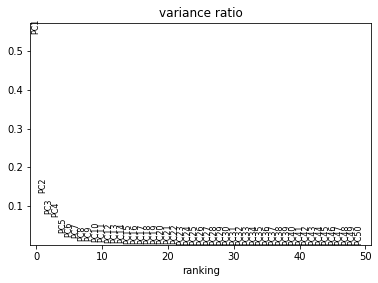

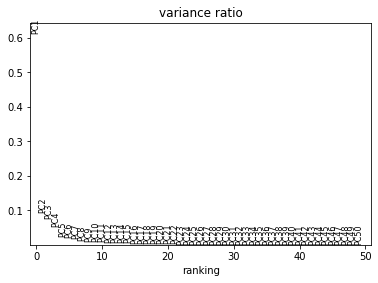

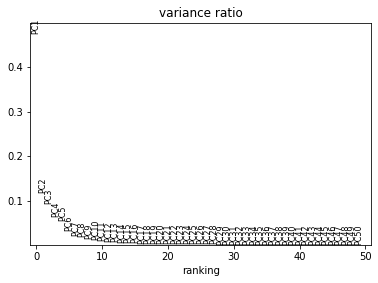

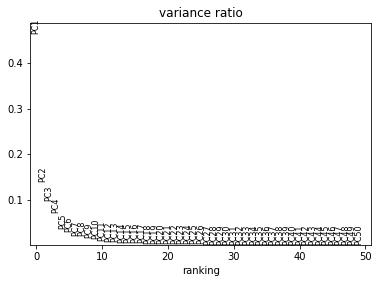

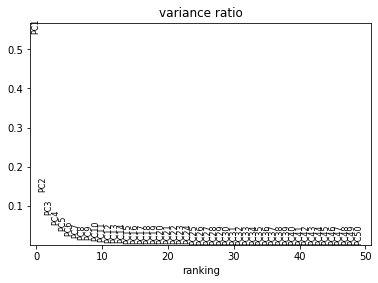

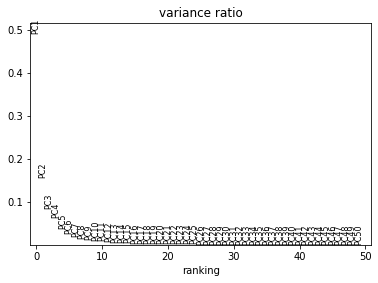

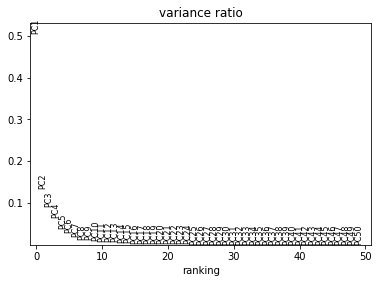

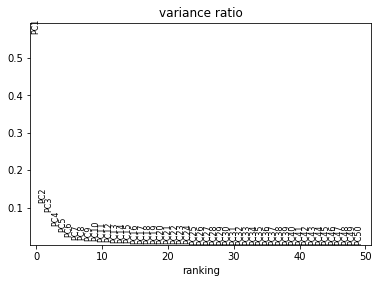

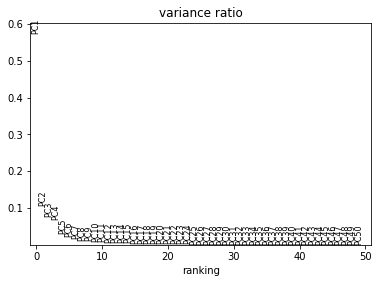

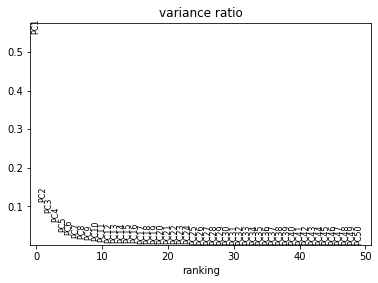

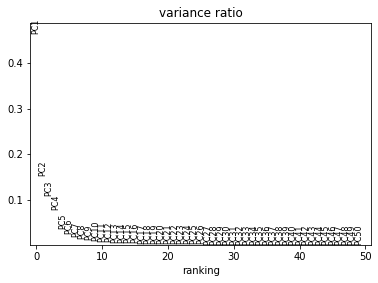

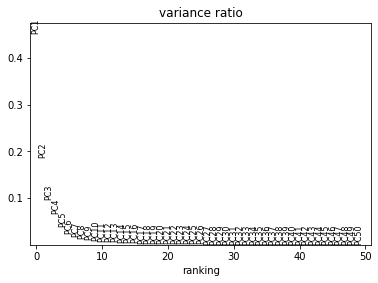

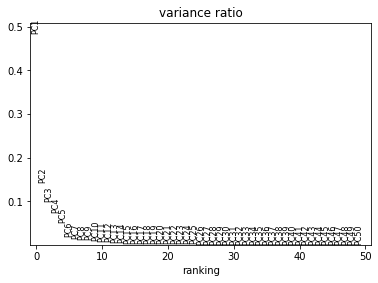

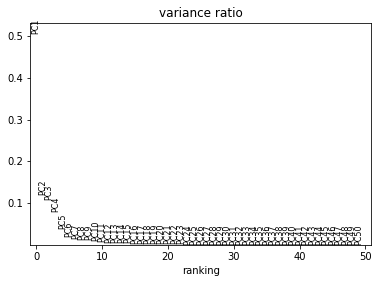

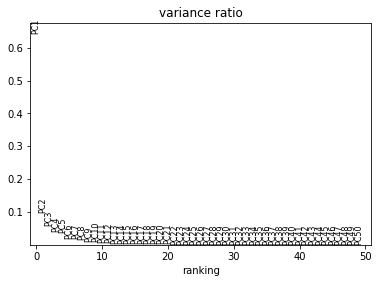

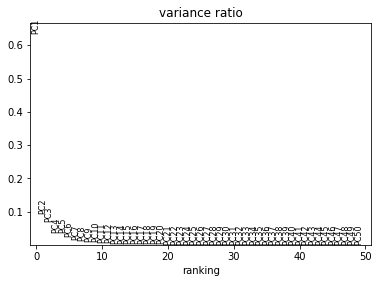

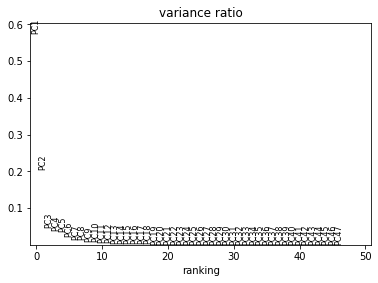

In [11]:
data_read_path = "../../../../cell_painting_data_lock/4_CS_OBJECTS_median_aggregated/"
data_read_suffix = "_PCH_rd_OG316"
save_path = "mahala_calculations/"

run = "CS_run1"
run_mahala_for_run(run=run,data_read_path=data_read_path,
                  data_read_suffix=data_read_suffix,save_path=save_path+"/"+run +"_",
                  adata=C316)

run = "CS_run2"
run_mahala_for_run(run=run,data_read_path=data_read_path,
                  data_read_suffix=data_read_suffix,save_path=save_path+"/"+run+"_",
                   adata=C316)

run = "CS_run3"
run_mahala_for_run(run=run,data_read_path=data_read_path,
                  data_read_suffix=data_read_suffix,save_path=save_path+"/"+run+"_",
                   adata=C316)

Um ok need to rerun stuff on run3 32x5r

Trying to set attribute `.obs` of view, copying.


32x5r_random1


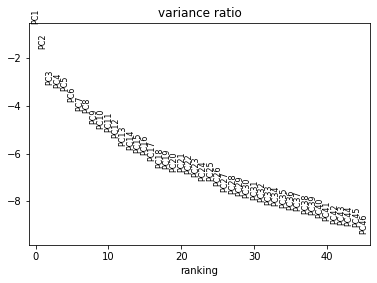

95% of variance explained by 9 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


Trying to set attribute `.obs` of view, copying.


32x5r_random2


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:538: RuntimeWarning: divide by zero encountered in log
  scores = np.log(scores)


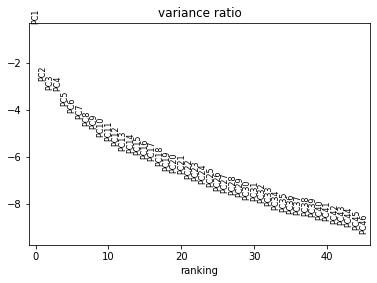

95% of variance explained by 9 PCs
Naive mahalanobis


/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Strap that boot!
0.0 percent done
10.0 percent done
20.0 percent done
30.0 percent done
40.0 percent done
50.0 percent done
60.0 percent done
70.0 percent done
80.0 percent done
90.0 percent done


In [8]:
data_read_path = "../../../../cell_painting_data_lock/4_CS_OBJECTS_median_aggregated/"
data_read_suffix = "_PCH_rd_OG316"
save_path = "mahala_calculations/"

run = "CS_run3"
data_read_path=data_read_path
data_read_suffix=data_read_suffix
save_path="mahala_calculations/"+run+"_"
adata=C316
compression = 32
replicates = 5
schemes = ['random1','random2']
for scheme in schemes:
# scheme = 'random2'

    save_prefix = str(compression) + "x"+str(replicates) + "r" +"_"+str(scheme)
    print(save_prefix)


    cs_adata = adata[(adata.obs.Metadata_run==run)&\
                   (adata.obs.Metadata_perturbation.isin([scheme, 'DMSO']))&\
                   (adata.obs.Metadata_compression==compression)&\
                   (adata.obs.Metadata_replicates==replicates),:]

    cs_adata.obs['design_index']=cs_adata.obs.Metadata_Plate.astype(str)+'_'+cs_adata.obs.Metadata_Well.astype(str)

    # load in design matricies
    run_design = pd.read_csv(data_read_path+run+data_read_suffix+"_design_matrix.csv",index_col=0).reset_index().rename(columns={'index':'design_index'})

    # add design matrix
    design_mat = pd.DataFrame(cs_adata.obs['design_index']).\
                 merge(run_design,how='left',on='design_index').\
                 drop(['design_index'],axis=1)

    cs_adata.obsm['design_matrix']=np.array(design_mat)
    cs_adata.uns['design_matrix_perturbations'] = design_mat.columns.values.tolist()

    # filter to reps
    plate = list(set(cs_adata.obs.loc[cs_adata.obs.Metadata_perturbation==scheme,'Metadata_Plate'].values))

    cs_adata1 = cs_adata[(cs_adata.obs.Metadata_Plate==plate[0]),:]

    # recalc PC's for dataset
    sc.pp.pca(cs_adata1)

    # single plate (no need to batch correct)

    sc.pl.pca_variance_ratio(cs_adata1, n_pcs = 45, log=True,show=None)
    # get num of PCs to use (up to 95% var explained)
    num_pcs = sum(np.cumsum(cs_adata1.uns['pca']['variance_ratio']) < 0.95)+1

    print('95% of variance explained by '+str(num_pcs)+' PCs')

    cs_adata1.obsm['X_pca']= cs_adata1.obsm['X_pca_harmony'][:,0:45]
    cs_adata1.obsm['X_pca_harmony']= cs_adata1.obsm['X_pca_harmony'][:,0:45]
    cs_adata1.uns['pca']['variance_ratio'] = cs_adata1.uns['pca']['variance_ratio'][0:45]

    mahala_table, mahalas_resampled = mahala_dist_CS_bootstrap(cs_adata1,std_cutoff=5, use_rep='X_pca_harmony', num_pcs=num_pcs,bootstrap=True)
    mahala_table['num_pcs_explaining_95var'] = num_pcs
    mahala_table.to_csv(save_path+save_prefix+"mahala_table_DMSO_1e7_samples_17Nov2021_empiricalcov.csv")
    np.save(save_path+save_prefix+"mahalas_resampled_DMSO_1e7_samples_17Nov2021_empiricalcov.npy",mahalas_resampled)